 <h2 style="color:#C0392B;" > Customer Churn Prediction </h2>

Customer churn refers to<h4 style="color:green;"> customers who stop using the company’s services, which directly impacts revenue, customer acquisition costs, and long-term profitability.</h4>

<h3> Definition of Churn </h3>

In this dataset, churn is defined as:

Churn = 1 → Customer has exited the bank.<br>
Churn = 0 → Customer is still active.

In a real FinTech scenario, churn may be defined as:

• No transactions for 90 consecutive days  
• Account closure  
• Subscription cancellation  
• Loan account inactive  


# Step 1. Imports

In [87]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Metrics & utilities
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings("ignore")

# Display settings
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.05)
pd.set_option('display.max_columns', 200)

# Step 2. Load the data

In [88]:
# Load dataset (adjust path if needed)
df = pd.read_excel("customer_data.xlsx")
print("Shape ( Total rows , Total Columns):", df.shape)

df.head()


Shape ( Total rows , Total Columns): (10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<h3>  Dataset Understanding & Business Interpretation
</h3>

Each row represents one customer.<br>
<h5 style="color:purple">Numerical Features:</h5>
CreditScore ,Age, Tenure, Balance , Products_Number , EstimatedSalary.<br>This represent customer financial strength and engagement<br>
<h5 style="color:purple">Categorical Features:</h5>Country, Gender, Credit_card , Active_member, Churn.<br>
This represent demographic and behavioral attributes

Balance    :   Indicates customer engagement level. Low balance may signal low usage.<br>
Tenure     :    Customer loyalty indicator. Short tenure customers are high churn risk.

# Step 3. Initial Inspection

In [89]:
# Info & Summary
display(df.info())
display(df.describe(include='all'). T)

# Missing values
print("\nMissing values per column:")
print(df.isnull().sum)

# Target distribution
print("\n  Churn value counts:")
print(df['churn'].value_counts(normalize=False))
print("\nChurn proportion:")
print(df['churn'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
credit_score,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
country,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
products_number,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
credit_card,10000.0,NaN,NaN,NaN,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0
active_member,10000.0,NaN,NaN,NaN,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0



Missing values per column:
<bound method DataFrame.sum of       customer_id  credit_score  country  gender    age  tenure  balance  \
0           False         False    False   False  False   False    False   
1           False         False    False   False  False   False    False   
2           False         False    False   False  False   False    False   
3           False         False    False   False  False   False    False   
4           False         False    False   False  False   False    False   
...           ...           ...      ...     ...    ...     ...      ...   
9995        False         False    False   False  False   False    False   
9996        False         False    False   False  False   False    False   
9997        False         False    False   False  False   False    False   
9998        False         False    False   False  False   False    False   
9999        False         False    False   False  False   False    False   

      products_number  credi

# Step 4. Exploratory Data Analysis (visualizations)

We'll look at distributions of numeric features, relationships with churn and categorical features

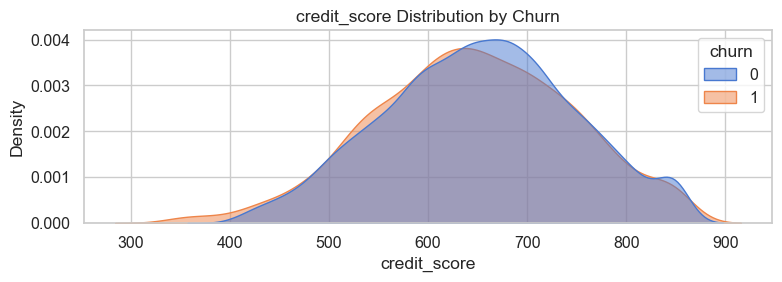

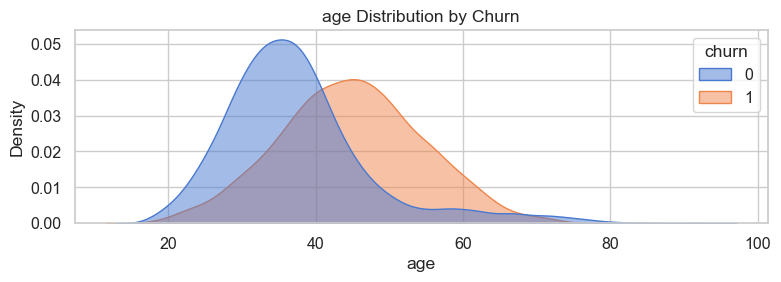

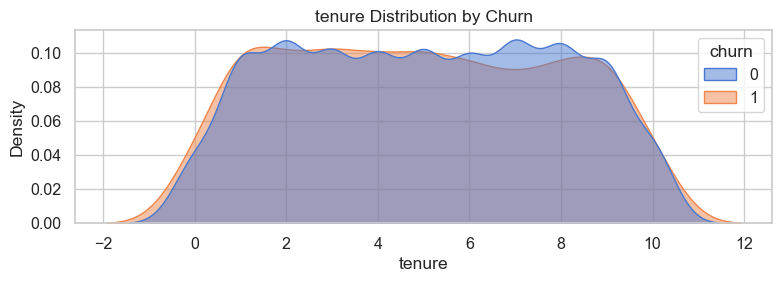

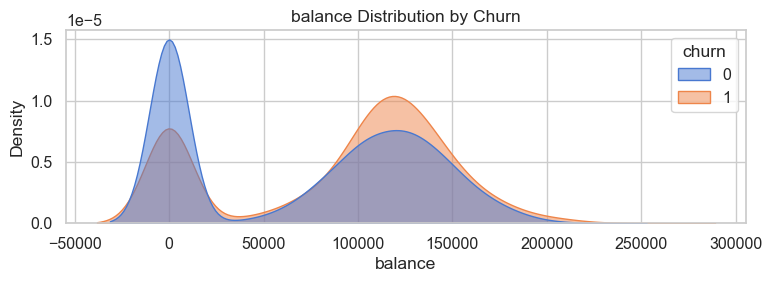

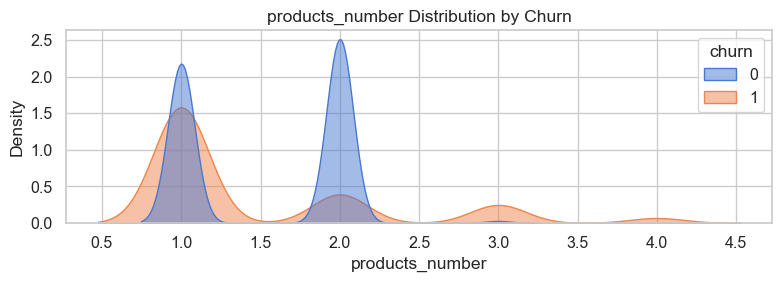

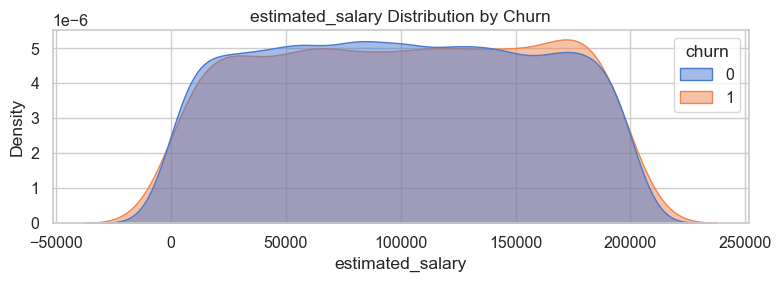

In [90]:
num_cols = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']

# --- Distribution plots
for col in num_cols:
    plt.figure(figsize=(8,3))
    sns.kdeplot(data=df, x=col, hue='churn', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'{col} Distribution by Churn')
    plt.tight_layout()
    plt.show()

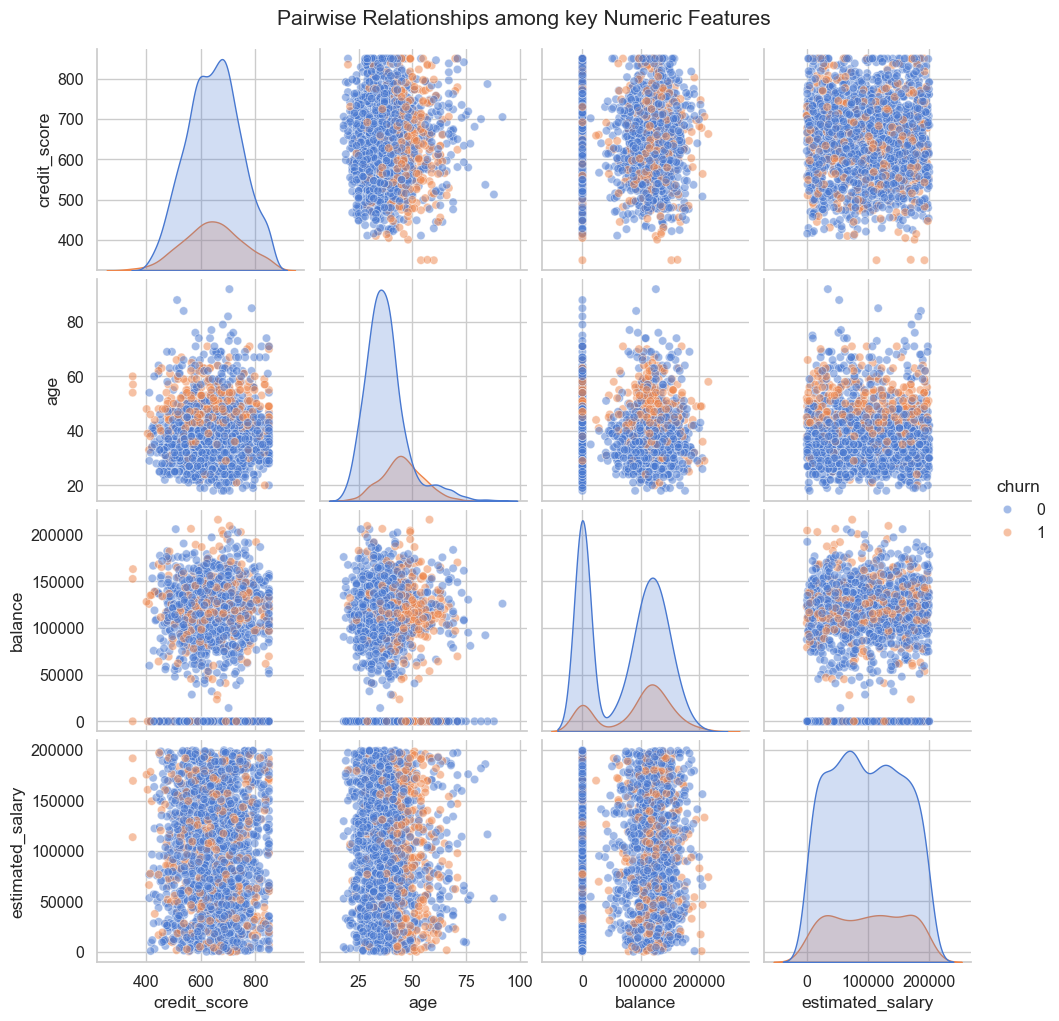

In [91]:
# --- Pairplot (sampled for speed)
sns.pairplot(df.sample(frac=0.2, random_state=42),
             vars=['credit_score', 'age', 'balance', 'estimated_salary'], 
            hue='churn', diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Relationships among key Numeric Features', y=1.02)
plt.show()

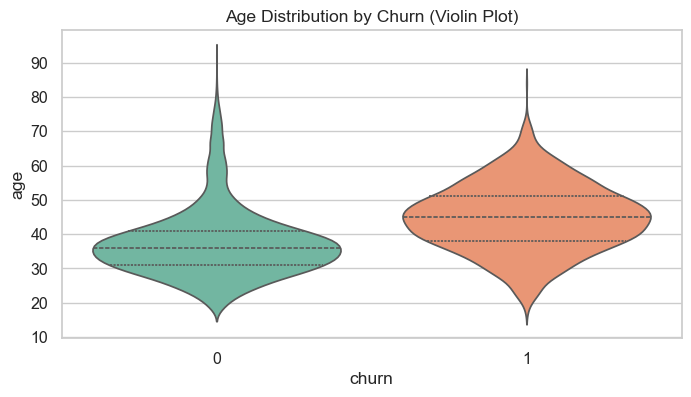

In [92]:
# --- Violin plot for Age
plt.figure(figsize=(8,4))
sns.violinplot(data=df, x='churn', y='age', inner='quart', palette='Set2')
plt.title('Age Distribution by Churn (Violin Plot)')
plt.show()

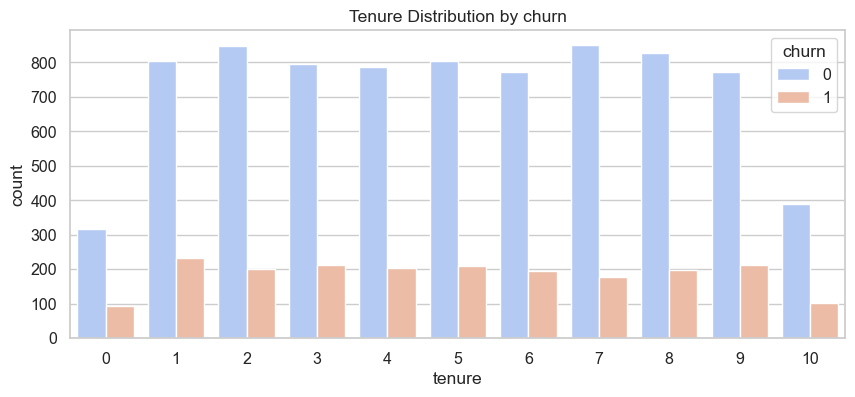

In [93]:
# --- Tenure distribution
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='tenure', hue='churn', palette='coolwarm')
plt.title('Tenure Distribution by churn')
plt.show()

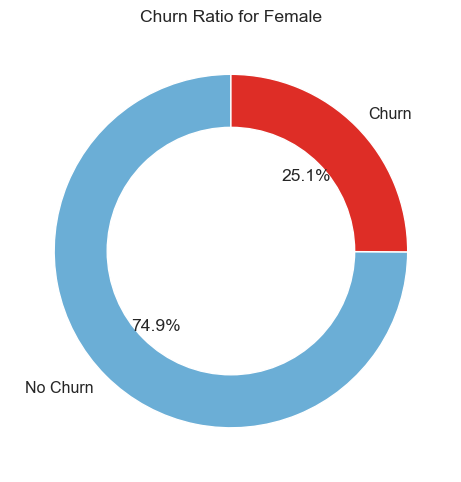

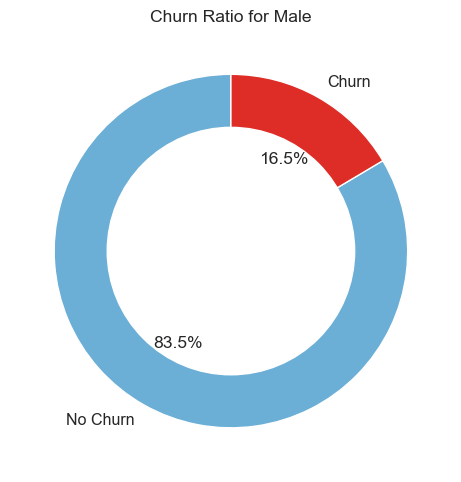

In [94]:
# --- Gender vs Churn Donut Chart
gender_counts = df.groupby('gender')['churn'].value_counts(normalize=True).unstack().fillna(0)
for gender in gender_counts.index:
    plt.figure(figsize=(5,5))
    plt.pie(gender_counts.loc[gender], labels=['No Churn', 'Churn'],
            autopct='%1.1f%%', startangle=90, colors=['#6baed6', '#de2d26'])
    center = plt.Circle((0,0),0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(center)
    plt.title(f'Churn Ratio for {gender}')
    plt.tight_layout()
    plt.show()

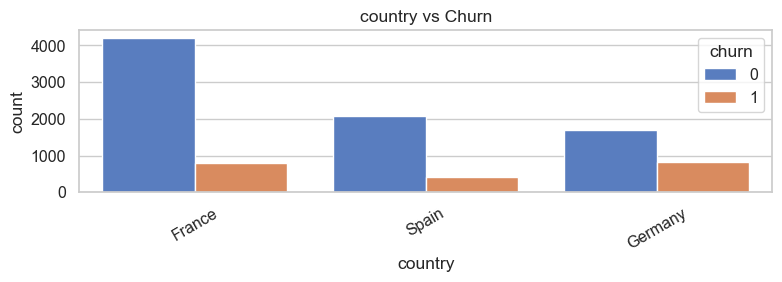

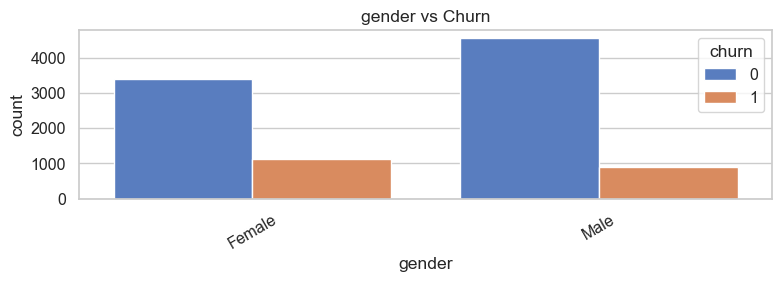

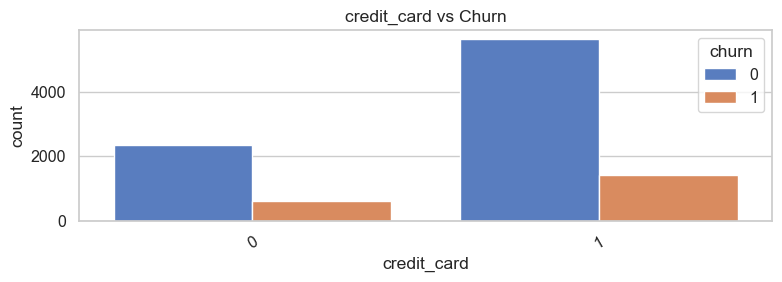

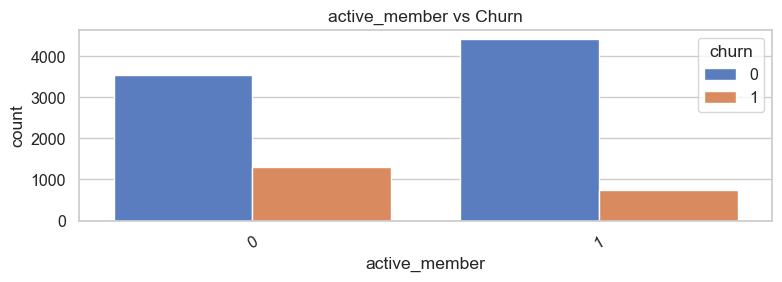

In [95]:
# --- Categorical features
cat_cols = ['country', 'gender', 'credit_card', 'active_member']
for c in cat_cols:
    plt.figure(figsize=(8,3))
    sns.countplot(data=df, x=c, hue='churn')
    plt.title(f'{c} vs Churn')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

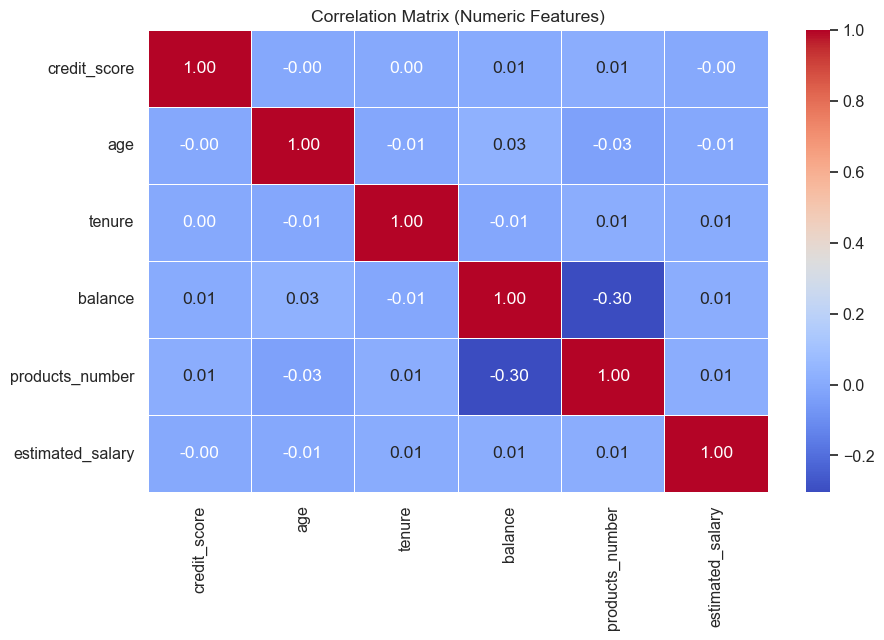

In [96]:
# --- Heatmap visualization
plt.figure(figsize=(10,6))
numeric_df = df[num_cols]
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

In [97]:
# --- Numeric Corellation heatmap
numeric_data = df[num_cols]  # use the numeric columns from your feature-engineered dataframe
corr = numeric_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,credit_score,age,tenure,balance,products_number,estimated_salary
credit_score,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.001384
age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.007201
tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.007784
balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,0.012797
products_number,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.014204
estimated_salary,-0.001384,-0.007201,0.007784,0.012797,0.014204,1.000000


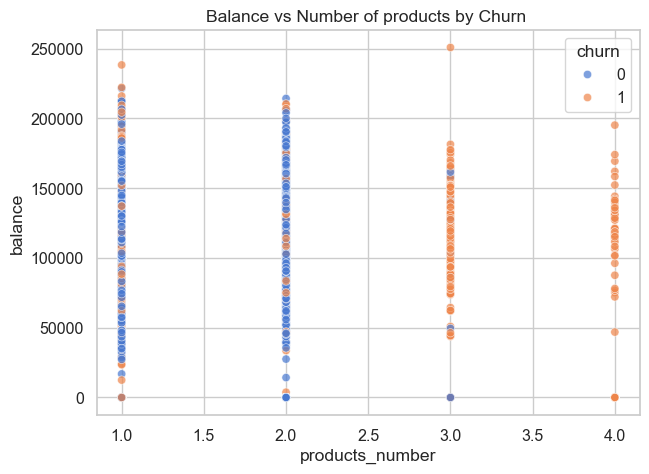

In [98]:
# --- Balance vs Products scatter
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='products_number', y='balance', hue='churn', alpha=0.7)
plt.title('Balance vs Number of products by Churn ')
plt.show()

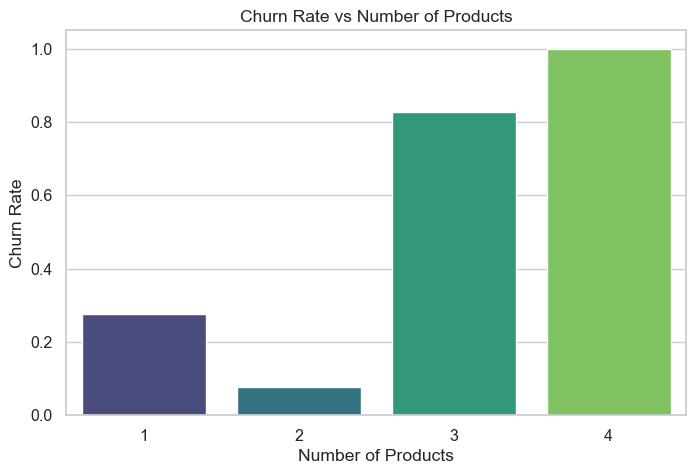

In [99]:
# --- Aggregate churn rate per number of products
churn_rate = df.groupby('products_number')['churn'].mean().reset_index()

# Plot churn rate
plt.figure(figsize=(8,5))
sns.barplot(data=churn_rate, x='products_number', y='churn', palette='viridis')
plt.xlabel('Number of Products')
plt.ylabel('Churn Rate')
plt.title('Churn Rate vs Number of Products')
plt.show()

In [100]:
# Overall churn rate
overall_churn = df['churn'].mean() * 100
print(f"Overall Churn Rate: {overall_churn:.2f}%")


Overall Churn Rate: 20.37%


Insight:
The dataset shows an overall churn rate of approximately 20.37%.
This indicates churn is a significant business risk and requires proactive retention strategies.


In [101]:
# Create balance quartiles
df['balance_group'] = pd.qcut(df['balance'], q=4, duplicates='drop')

balance_churn = df.groupby('balance_group')['churn'].mean() * 100
print(balance_churn)


balance_group
(-0.001, 97198.54]        15.76
(97198.54, 127644.24]     26.28
(127644.24, 250898.09]    23.68
Name: churn, dtype: float64


Insight:
Customers in lower balance segments show higher churn probability.
Low balance may indicate low engagement or inactive usage.


In [102]:
# Churn by Tenure
tenure_churn = df.groupby('tenure')['churn'].mean() * 100
print(tenure_churn.head())


tenure
0    23.002421
1    22.415459
2    19.179389
3    21.110010
4    20.525784
Name: churn, dtype: float64


Insight:
Customers with lower tenure show higher churn rates.
This suggests onboarding experience is critical in early customer lifecycle.


In [103]:
# Churn by Number of Products
product_churn = df.groupby('products_number')['churn'].mean() * 100
print(product_churn)


products_number
1     27.714398
2      7.581699
3     82.706767
4    100.000000
Name: churn, dtype: float64


Insight:
Customers using fewer financial products churn more frequently.
Multi-product customers demonstrate higher loyalty and stickiness.


In [104]:
# Churn by Active Membership

active_churn = df.groupby('active_member')['churn'].mean() * 100
print(active_churn)


active_member
0    26.850897
1    14.269074
Name: churn, dtype: float64


Insight:
Inactive customers show significantly higher churn.
Customer engagement is a strong predictor of retention.


## Key Business Insights from EDA

1. Customers with lower balances show higher churn probability.
2. Customers with fewer financial products churn more.
3. New customers (low tenure) are at higher churn risk.
4. Inactive customers show significantly higher churn rates.
5. Engagement and product penetration are strong retention drivers.

These insights highlight that churn is primarily driven by customer engagement levels.


# Step 5. Feature Engineering
Create meaningful features: e.g balance per product, age group, salary bracket and handle missing values.

In [105]:
# Feature engineering examples
df_fe = df.copy()

# Balance per product
df_fe['balance_per_product'] = df_fe['balance'] / (df_fe['products_number'].replace(0, np.nan))
df_fe['balance_per_product'].fillna(0, inplace=True)

# Salary to balance ratio
df_fe['salary_balance_ratio'] = df_fe['estimated_salary'] / (df_fe['balance'].replace(0, np.nan))
df_fe['salary_balance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_fe['salary_balance_ratio'].fillna(df_fe['salary_balance_ratio'].median(), inplace=True)

# Age group
bins = [0,25,35,45,55,65,100]
labels = ['<25','25-34','35-44','45-54','55-64','65+']
df_fe['age_group'] = pd.cut(df_fe['age'], bins=bins, labels=labels)

# Tenure bucket
df_fe['tenure_bucket'] = pd.cut(df_fe['tenure'], bins=[-1,0,2,5,10,100], labels=['0','1-2','3-5','6-10','10+'])

# Flag high balance
df_fe['high_balance'] = (df_fe['balance'] > df_fe['balance'].quantile(0.75)).astype(int)

# Quick checks
df_fe[['balance_per_product','salary_balance_ratio','age','age_group','tenure','tenure_bucket','high_balance']].head()

,balance_per_product,salary_balance_ratio,age,age_group,tenure,tenure_bucket,high_balance
0,0.000000,0.839258,42,35-44,2,1-2,0
1,83807.860000,1.342864,41,35-44,1,1-2,0
2,53220.266667,0.713585,42,35-44,8,6-10,1
3,0.000000,0.839258,39,35-44,1,1-2,0
4,125510.820000,0.630098,43,35-44,2,1-2,0


In [106]:
# Customer Engagement Score (0–3 scale)
df_fe['engagement_score'] = (
    df_fe['active_member'].astype(int) +
    (df_fe['products_number'] > 1).astype(int) +
    (df_fe['balance'] > df_fe['balance'].median()).astype(int)
)
df_fe['engagement_score']

0       1
1       1
2       2
3       1
4       2
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: engagement_score, Length: 10000, dtype: int64

In [107]:
# Value segmentation based on balance
 # Initialize column with NaN (object type)
df_fe['customer_value_segment'] = pd.Series(dtype='object')

# Assign No Balance
df_fe.loc[df_fe['balance'] == 0, 'customer_value_segment'] = 'No Balance'

# Apply qcut only for non-zero balances
non_zero_mask = df_fe['balance'] > 0

df_fe.loc[non_zero_mask, 'customer_value_segment'] = pd.qcut(
    df_fe.loc[non_zero_mask, 'balance'],
    q=3,
    labels=['Low Value', 'Medium Value', 'High Value']
).astype(str)

# Check distribution
df_fe['customer_value_segment'].value_counts()


customer_value_segment
No Balance      3617
Low Value       2128
High Value      2128
Medium Value    2127
Name: count, dtype: int64

In [108]:
# Risk segmentation
df_fe['risk_segment'] = pd.cut(
    df_fe['credit_score'],
    bins=[0,580,670,740,850],
    labels=['Poor','Fair','Good','Excellent']
)
df_fe['risk_segment']

0            Fair
1            Fair
2            Poor
3            Good
4       Excellent
          ...    
9995    Excellent
9996         Poor
9997         Good
9998    Excellent
9999    Excellent
Name: risk_segment, Length: 10000, dtype: category
Categories (4, object): ['Poor' < 'Fair' < 'Good' < 'Excellent']

In [109]:
# Activity intensity approximation
df_fe['activity_intensity'] = df_fe['tenure'] * df_fe['products_number']
df_fe['activity_intensity']

0        2
1        1
2       24
3        2
4        2
        ..
9995    10
9996    10
9997     7
9998     6
9999     4
Name: activity_intensity, Length: 10000, dtype: int64

In [110]:
# Basic churn risk proxy
df_fe['basic_risk_score'] = (
    (df_fe['tenure'] <= 2).astype(int) +
    (df_fe['products_number'] == 1).astype(int) +
    (df_fe['active_member'] == 0).astype(int)
)
df_fe['basic_risk_score']

0       2
1       2
2       1
3       2
4       2
       ..
9995    1
9996    1
9997    1
9998    1
9999    2
Name: basic_risk_score, Length: 10000, dtype: int64

In [111]:
df_fe.head()


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,balance_group,balance_per_product,salary_balance_ratio,age_group,tenure_bucket,high_balance,engagement_score,customer_value_segment,risk_segment,activity_intensity,basic_risk_score
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(-0.001, 97198.54]",0.000000,0.839258,35-44,1-2,0,1,No Balance,Fair,2,2
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(-0.001, 97198.54]",83807.860000,1.342864,35-44,1-2,0,1,Low Value,Fair,1,2
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(127644.24, 250898.09]",53220.266667,0.713585,35-44,6-10,1,2,High Value,Poor,24,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,"(-0.001, 97198.54]",0.000000,0.839258,35-44,1-2,0,1,No Balance,Good,2,2
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,"(97198.54, 127644.24]",125510.820000,0.630098,35-44,1-2,0,2,Medium Value,Excellent,2,2


## Business-Driven Feature Engineering

New features were created to better capture:

• Customer engagement level <br>
• Product stickiness<br>
• Credit risk segment<br>
• Customer value tier<br>
• Relationship intensity<br>

These features simulate real-world FinTech scoring systems.


# Step 6. Preprocessing - encoding & scaling
We'll build a preprocessing pipeline that encodes categorical features and scales numerical ones.

In [112]:
# Define features and target
target = 'churn'
drop_cols = ['customer_id']
features = [c for c in df_fe.columns if c not in [target] + drop_cols]

numeric_features = ['credit_score','age','tenure','balance','products_number','estimated_salary',
                    'balance_per_product','salary_balance_ratio']
categorical_features = ['country','gender','credit_card','active_member','age_group','tenure_bucket','high_balance']

df_fe[categorical_features] = df_fe[categorical_features].astype('object')

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Numeric features: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary', 'balance_per_product', 'salary_balance_ratio']
Categorical features: ['country', 'gender', 'credit_card', 'active_member', 'age_group', 'tenure_bucket', 'high_balance']
Confusion Matrix:
[[1537   56]
 [ 208  199]]
True Negatives (TN): 1537
False Positives (FP): 56
False Negatives (FN): 208
True Positives (TP): 199


## Business Interpretation of Model Errors

False Positives (FP):
Customers predicted to churn but actually stayed.
Business Impact:
• Unnecessary retention offer.
• Minor marketing cost.

False Negatives (FN):
Customers predicted to stay but actually churned.
Business Impact:
• Direct revenue loss.
• Loss of lifetime customer value.
• Higher cost to acquire replacement customer.

In churn prediction, False Negatives are more dangerous than False Positives.
Therefore, Recall is prioritized over Accuracy.


## Why Recall is Critical in Churn Prediction

Recall measures how many actual churn customers were correctly identified.

High recall ensures most high-risk customers are detected,
allowing proactive retention strategies.

In FinTech, missing a churn customer (False Negative)
can lead to significant financial loss.


# Step 7. Train Test split

In [113]:
X = df_fe[features]
y = df_fe[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train churn proportion:', y_train.mean(), 'Test churn proportion:', y_test.mean())

Train shape: (8000, 21) Test shape: (2000, 21)
Train churn proportion: 0.20375 Test churn proportion: 0.2035


In [114]:
# Class Imbalance Handling
print("Training class distribution:")
print(y_train.value_counts())

print("\nTraining class proportion:")
print(y_train.value_counts(normalize=True))


Training class distribution:
churn
0    6370
1    1630
Name: count, dtype: int64

Training class proportion:
churn
0    0.79625
1    0.20375
Name: proportion, dtype: float64


Observation:
The dataset is imbalanced, with churn representing approximately 20% of customers.
This can cause the model to bias toward predicting non-churn customers.


# Step 8. Train Multiple models with a pipeline and compare using cross-validation

In [115]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=500, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=42),
    'SVC': SVC(probability=True, random_state=42, class_weight='balanced')
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f"{name} AUC: Mean={scores.mean():.4f} Std={scores.std():.4f}")

LogisticRegression AUC: Mean=0.7884 Std=0.0243
RandomForest AUC: Mean=0.8487 Std=0.0141
GradientBoosting AUC: Mean=0.8628 Std=0.0097
AdaBoost AUC: Mean=0.8462 Std=0.0133
SVC AUC: Mean=0.8482 Std=0.0115


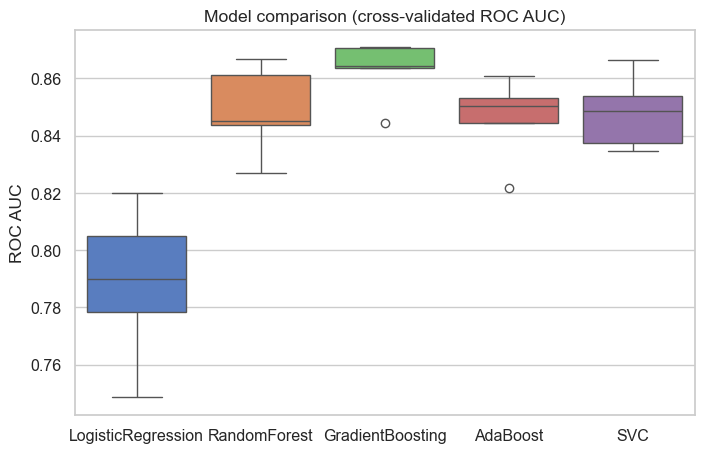

In [116]:
# Boxplot of CV AUC scores
plt.figure(figsize=(8,5))
sns.boxplot(data=[results[m] for m in list(results.keys())])
plt.xticks(ticks=range(len(results)), labels=list(results.keys()))
plt.ylabel('ROC AUC')
plt.title('Model comparison (cross-validated ROC AUC)')
plt.show()

In [117]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

for name, model in models.items():
    pipe = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f"{name} AUC with SMOTE: Mean={scores.mean():.4f}")


LogisticRegression AUC with SMOTE: Mean=0.7865
RandomForest AUC with SMOTE: Mean=0.8446
GradientBoosting AUC with SMOTE: Mean=0.8614
AdaBoost AUC with SMOTE: Mean=0.8470
SVC AUC with SMOTE: Mean=0.8360


In [118]:
print("Recall:", recall_score(y_test, y_pred))


Recall: 0.48894348894348894


<H4>Class Imbalance Handling</H4>

Since churn represents only ~20% of customers,
class_weight and SMOTE were applied to reduce bias
toward the majority class.

This improves recall and ensures high-risk churn
customers are not ignored.


# Step 9. Fit best model on full train set and evaluate on test set
Select best model by mean CV AUC above and evaluate standard metrics on the test set

In [119]:
# Choose best model (automatic pick by mean AUC)
best_name = max(results.keys(), key=lambda k: results[k].mean())
best_name, results[best_name].mean()

('GradientBoosting', np.float64(0.8613858096329613))

Test Accuracy: 0.8680
Test Precision: 0.7804
Test Recall: 0.4889
Test F1-score: 0.6012
Test ROC AUC: 0.8692

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.78      0.49      0.60       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



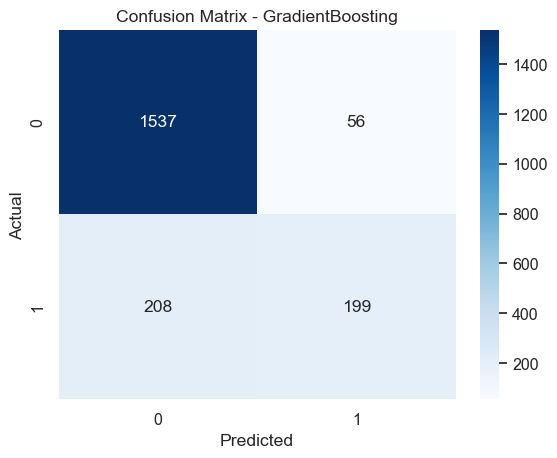

In [120]:
best_model = models[best_name]
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', best_model)])
best_pipeline.fit(X_train, y_train)

# Predictions
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1-score: {f1:.4f}")
print(f"Test ROC AUC: {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_name}')
plt.show()

<H4> Model Interpretation </h4>

Top 5 Important Features:


age                    0.327665
products_number        0.266459
balance_per_product    0.063396
balance                0.056953
active_member_0        0.052653
dtype: float64

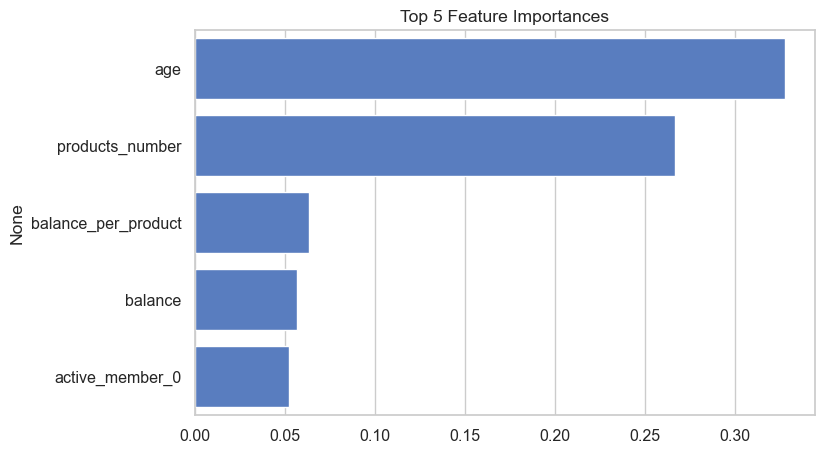

In [121]:
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    
    # Get feature names after preprocessing
    num_feats = numeric_features
    
    cat_feats = list(
        best_pipeline.named_steps['preprocessor']
        .transformers_[1][1]
        .named_steps['onehot']
        .get_feature_names_out(categorical_features)
    )
    
    feature_names = num_feats + cat_feats
    
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    
    top5 = fi.head(5)
    
    print("Top 5 Important Features:")
    display(top5)
    
    plt.figure(figsize=(8,5))
    sns.barplot(x=top5.values, y=top5.index)
    plt.title("Top 5 Feature Importances")
    plt.show()
    
else:
    print("Selected model does not support feature importance.")



These features indicate that customer engagement,
product usage depth, and financial activity
are primary churn drivers.

In [122]:
!pip install shap



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


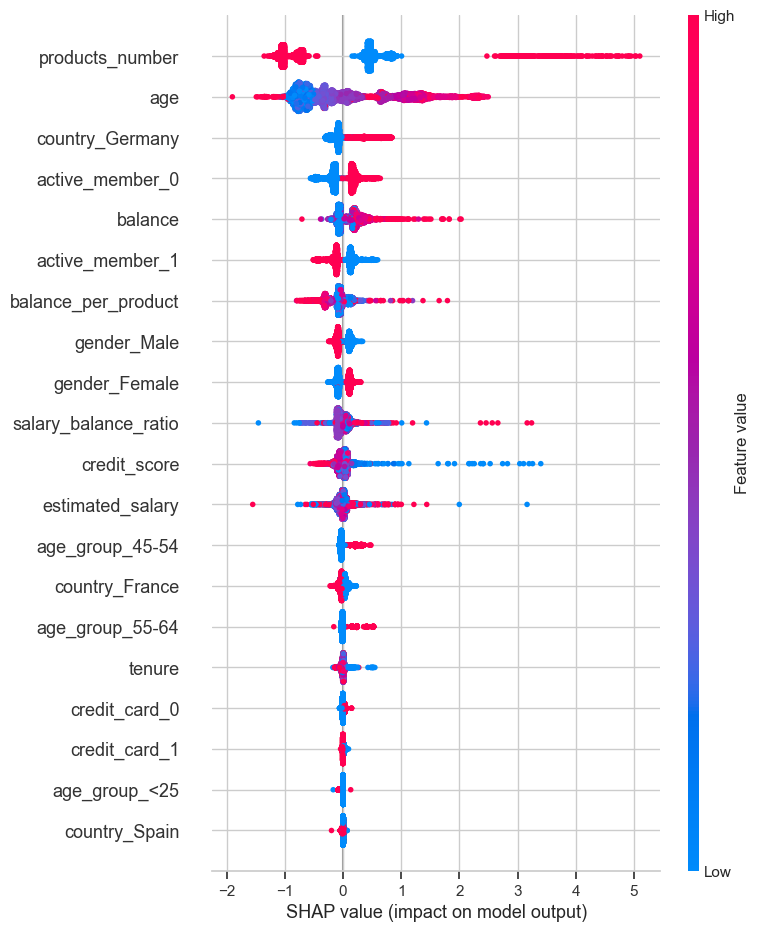

In [123]:
import shap

# Extract trained classifier
clf = best_pipeline.named_steps['classifier']

# Transform training data
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)

# Create SHAP explainer
explainer = shap.TreeExplainer(clf)

# Get SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# Handle binary classification properly
if isinstance(shap_values, list):
    shap_matrix = shap_values[1]   # For class 1 (churn)
else:
    shap_matrix = shap_values      # Newer SHAP versions

# Summary plot
shap.summary_plot(shap_matrix, X_train_transformed, feature_names=feature_names)


SHAP Analysis Interpretation:

SHAP values show how each feature contributes to churn prediction.

Features pushing values to the right increase churn probability.
Features pushing values to the left reduce churn probability.

This ensures model transparency and regulatory compliance.


# Step 10. Feature importance (if applicable)
If the chosen model supports feature importance (RandomForest/GradientBoosting), show top features

Top 10 Features Influencing Churn (% Importance):


age                     32.766543
products_number         26.645881
balance_per_product      6.339569
balance                  5.695269
active_member_0          5.265339
country_Germany          5.068882
active_member_1          4.799244
salary_balance_ratio     2.999173
estimated_salary         2.554720
credit_score             2.268545
dtype: float64

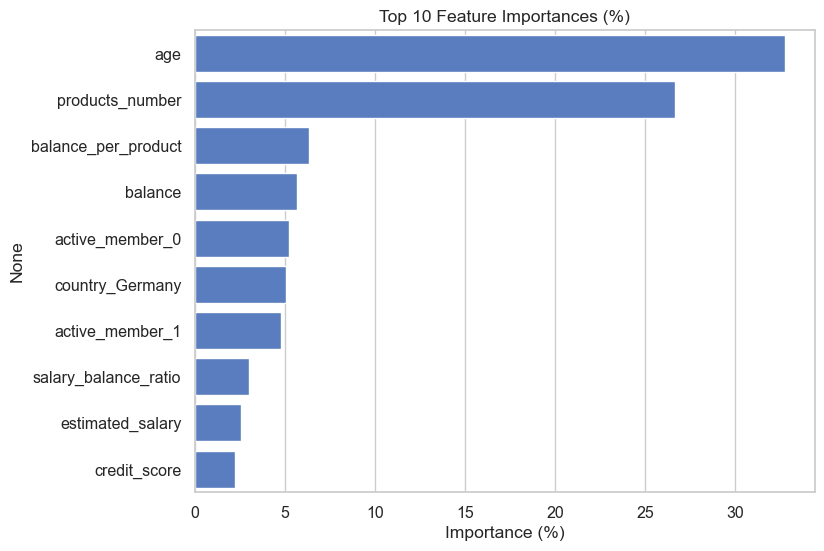

In [124]:
# Step 10. Model Interpretation

if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    
    # Extract feature names
    num_feats = numeric_features
    
    cat_feats = list(
        best_pipeline.named_steps['preprocessor']
        .transformers_[1][1]
        .named_steps['onehot']
        .get_feature_names_out(categorical_features)
    )
    
    feature_names = num_feats + cat_feats
    
    # Extract importance
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    
    fi = pd.Series(importances, index=feature_names)
    
    # Normalize importance
    fi_normalized = (fi / fi.sum()) * 100
    
    fi_sorted = fi_normalized.sort_values(ascending=False)
    
    # Top 10 features
    top_features = fi_sorted.head(10)
    
    print("Top 10 Features Influencing Churn (% Importance):")
    display(top_features)
    
    # Plot
    plt.figure(figsize=(8,6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title("Top 10 Feature Importances (%)")
    plt.xlabel("Importance (%)")
    plt.show()

else:
    print("Selected model does not support feature_importances_.")


<h4> Business Interpretation of Top Churn Drivers </h4>

Based on feature importance:

1. High importance of engagement_score indicates that inactive or low-engagement customers are most likely to churn.

2. products_number importance suggests customers using fewer products lack platform stickiness.

3. tenure importance shows early-stage customers are more vulnerable to churn.

4. balance_per_product indicates financial depth of engagement affects retention.

5. risk_segment highlights creditworthiness impact on customer lifecycle.

These insights align with real-world FinTech customer behavior.


In [125]:
print("Top 5 Features:")
display(fi_sorted.head(5))

print("\nBottom 5 Features:")
display(fi_sorted.tail(5))


Top 5 Features:


age                    32.766543
products_number        26.645881
balance_per_product     6.339569
balance                 5.695269
active_member_0         5.265339
dtype: float64


Bottom 5 Features:


age_group_65+         0.007664
age_group_25-34       0.002403
tenure_bucket_6-10    0.000535
high_balance_1        0.000153
tenure_bucket_0       0.000000
dtype: float64

 96%|=================== | 7701/8000 [00:23<00:00]       

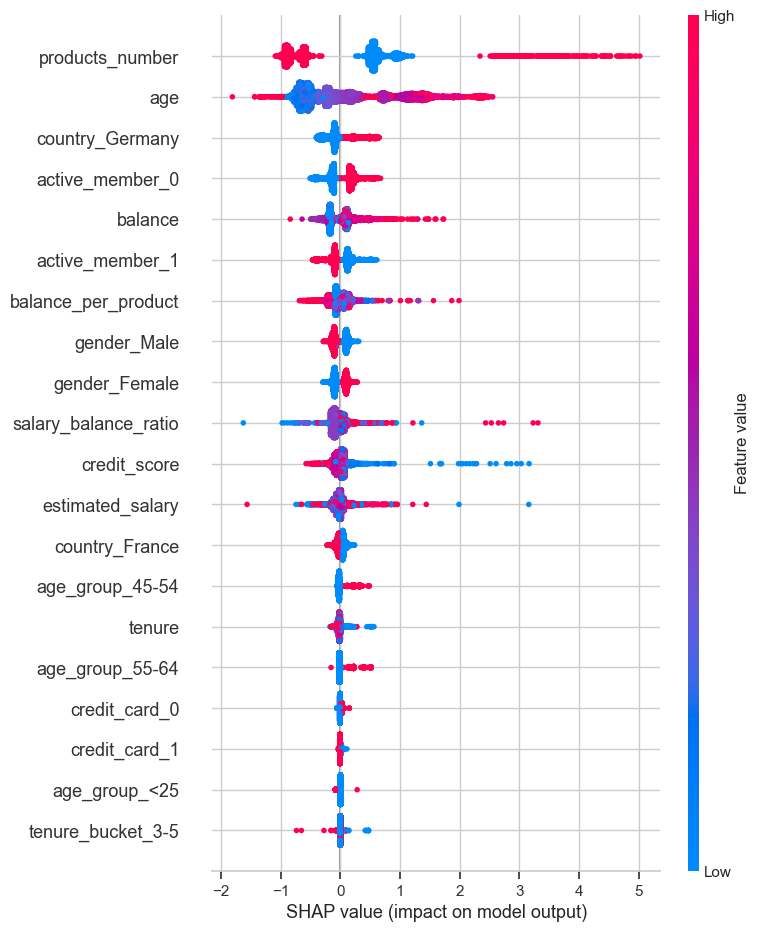

In [126]:
import shap

clf = best_pipeline.named_steps['classifier']
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)

explainer = shap.Explainer(clf, X_train_transformed)
shap_values = explainer(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)


# Step 11. Save the best pipeline and preprocessing artifacts

In [127]:
joblib.dump(best_pipeline, 'best_churn_pipeline.pkl')
print("Saved pipeline: best_churn_pipeline.pkl")

Saved pipeline: best_churn_pipeline.pkl


# Step 12. Example: Predict churn for a new customer

In [128]:
def apply_feature_engineering(df_input):
    df_temp = df_input.copy()
    
    # Balance per product
    df_temp['balance_per_product'] = df_temp['balance'] / (
        df_temp['products_number'].replace(0, np.nan)
    )
    df_temp['balance_per_product'].fillna(0, inplace=True)

    # Salary to balance ratio
    df_temp['salary_balance_ratio'] = df_temp['estimated_salary'] / (
        df_temp['balance'].replace(0, np.nan)
    )
    df_temp['salary_balance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_temp['salary_balance_ratio'].fillna(
        df_temp['salary_balance_ratio'].median(), inplace=True
    )

    # Age group
    bins = [0,25,35,45,55,65,100]
    labels = ['<25','25-34','35-44','45-54','55-64','65+']
    df_temp['age_group'] = pd.cut(df_temp['age'], bins=bins, labels=labels)

    # Tenure bucket
    df_temp['tenure_bucket'] = pd.cut(
        df_temp['tenure'],
        bins=[-1,0,2,5,10,100],
        labels=['0','1-2','3-5','6-10','10+']
    )

    # High balance
    balance_threshold = df_fe['balance'].quantile(0.75)
    df_temp['high_balance'] = (df_temp['balance'] > balance_threshold).astype(int)

    # Engagement score
    df_temp['engagement_score'] = (
        df_temp['active_member'].astype(int) +
        (df_temp['products_number'] > 1).astype(int) +
        (df_temp['balance'] > df_fe['balance'].median()).astype(int)
    )

    # Activity intensity
    df_temp['activity_intensity'] = df_temp['tenure'] * df_temp['products_number']

    # Basic risk score
    df_temp['basic_risk_score'] = (
        (df_temp['tenure'] <= 2).astype(int) +
        (df_temp['products_number'] == 1).astype(int) +
        (df_temp['active_member'] == 0).astype(int)
    )

    return df_temp


In [129]:
# New customer sample
sample = {
    'customer_id': 373292028,
    'credit_score': 650,
    'country': 'France',
    'gender': 'Male',
    'age': 40,
    'tenure': 3,
    'balance': 50000.0,
    'products_number': 2,
    'credit_card': 1,
    'active_member': 1,
    'estimated_salary': 60000.0
}

sample_df = pd.DataFrame([sample])

# Apply feature engineering
sample_df = apply_feature_engineering(sample_df)

# Drop ID
sample_df = sample_df.drop(columns=['customer_id'])

# Predict
pred = best_pipeline.predict(sample_df)[0]
prob = best_pipeline.predict_proba(sample_df)[0,1]

print(f"Predicted churn: {pred}")
print(f"Probability of churn: {prob:.3f}")


Predicted churn: 0
Probability of churn: 0.030


In [130]:
if prob > 0.7:
    risk_level = "High Risk"
elif prob > 0.4:
    risk_level = "Medium Risk"
else:
    risk_level = "Low Risk"

print(f"Customer Risk Level: {risk_level}")


Customer Risk Level: Low Risk


## Individual Customer Prediction

The model predicts churn probability for a new customer.

Risk levels are categorized as: <br>
• High Risk (>70%) <br>
• Medium Risk (40–70%) <br>
• Low Risk (<40%)

This enables proactive retention strategy.


In [131]:
joblib.dump(best_pipeline, 'best_churn_pipeline.pkl')


['best_churn_pipeline.pkl']

In [132]:
balance_threshold = df_fe['balance'].quantile(0.75)
balance_median = df_fe['balance'].median()

joblib.dump(balance_threshold, 'balance_threshold.pkl')
joblib.dump(balance_median, 'balance_median.pkl')


['balance_median.pkl']

In [133]:
pip install streamlit


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
